## Importing Libraries

In [2]:
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
from scipy import signal
import cv2 as cv
from tqdm import tqdm

## Loading image

In [41]:
main_img = cv.imread('im04.jpg').astype(np.float32)

In [3]:
main_img.shape

(2355, 1765, 3)

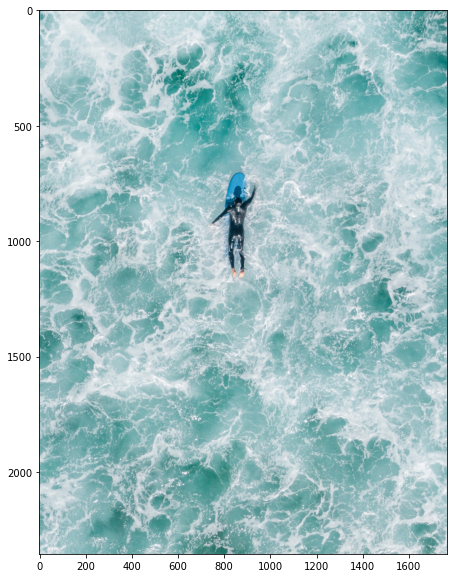

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(main_img.astype(np.uint8), cv.COLOR_BGR2RGB));

## Removing the object

In [42]:
rect_coords = ([670, 717], [1177, 997])
main_mask = np.ones_like(main_img, dtype=bool)
main_mask[rect_coords[0][0]:rect_coords[1][0], rect_coords[0][1]:rect_coords[1][1]] = False
main_img[~main_mask] = 0

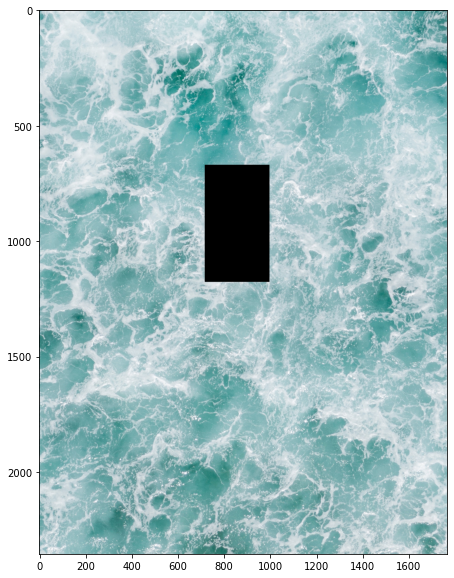

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(main_img.astype(np.uint8), cv.COLOR_BGR2RGB));

## Filling the rectangle

We use the method used in the previous problem. But, we change it a bit so that it works better here. The trick is to use all directions rather than just using top and left directions. Assume that we want to fill in a block in our image. We check whether this block has overlaps with each of the four directions(top, left, bottom and right). And after that, for calculating distance and min cut, we concider all of the overlaps(not just the top one and the left one).

Most of the functions are from the previous problem. So, I don't go through details for each of them.

In [3]:
def get_random_block(im, size):
    i = np.random.randint(im.shape[0] - size)
    j = np.random.randint(im.shape[1] - size)
    return im[i:i+size, j:j+size]

In [4]:
def l2_dist(texture_block, im, i_range, j_range, im_mask):
    i_s, i_e = i_range
    j_s, j_e = j_range
    return np.sum(((texture_block - im[i_s:i_e, j_s:j_e]) ** 2) * im_mask[i_s:i_e, j_s:j_e])

In [5]:
def find_best_l2_diff_coords(search_coords, im, i_range, j_range, im_mask, randomize=False, N=10):
    i_s, i_e = search_coords[0]
    j_s, j_e = search_coords[1]
    dist_arr = []
    coords_arr = []
    i_diff, j_diff = i_range[1]-i_range[0], j_range[1]-j_range[0]
    for i in range(i_s, i_e+1):
        for j in range(j_s, j_e+1):
            if i+i_diff >= im.shape[0] or j+j_diff >= im.shape[1]:
                continue
            if not np.all(im_mask[i:i+i_diff, j:j+j_diff]):
                continue
            dist = l2_dist(im[i:i+i_diff, j:j+j_diff], im, i_range, j_range, im_mask)
            dist_arr.append(dist)
            coords_arr.append((i, j))
    if randomize:
        idx = np.random.choice(np.argsort(dist_arr)[:N])
    else:
        idx = np.argmin(dist_arr)
    i_s, j_s = coords_arr[idx]
    
    return (i_s, i_s+i_diff), (j_s, j_s+j_diff)

In [6]:
def min_cut_path_mask(cost_arr):
    dp = np.zeros_like(cost_arr)
    directions = np.zeros_like(cost_arr, dtype=int) # 0: left-up, 1: left-middle, 2: left:down
    dp[:, 0] = cost_arr[:, 0]
    for j in range(1, cost_arr.shape[1]):
        for i in range(cost_arr.shape[0]):
            options = np.array([np.inf, dp[i, j-1], np.inf])
            if i > 0:
                options[0] = dp[i-1, j-1]
            if i < directions.shape[0]-1:
                options[2] = dp[i+1, j-1]
            directions[i, j] = np.argmin(options + cost_arr[i, j])
            dp[i, j] = dp[i+directions[i, j]-1, j-1] + cost_arr[i, j]
    mask = np.zeros_like(cost_arr, dtype=bool)
    tmp = (np.argmin(dp[:, -1]), directions.shape[1]-1)
    while tmp[1] >= 0:
        mask[tmp[0], tmp[1]] = True
        tmp = (tmp[0]+directions[tmp[0], tmp[1]]-1, tmp[1]-1)
    return mask

In [7]:
def fill_above_with_true(mask):
    for j in range(mask.shape[1]):
        idx = np.where(mask[:, j])[0][0]
        mask[:idx, j] = True
    return mask

def fill_below_with_true(mask):
    for j in range(mask.shape[1]):
        idx = np.where(mask[:, j])[0][0]
        mask[idx:, j] = True
    return mask

Using the given mask, calculate the overlap size in a specific direction

In [8]:
def get_overlap_size(mask, direction):
    i_f, j_f = np.where(mask == False)[0][0], np.where(mask == False)[1][0]
    if direction == 'top':
        return np.sum(mask[:i_f, j_f, 0])
    elif direction == 'left':
        return np.sum(mask[i_f, :j_f, 0])
    elif direction == 'bottom':
        return np.sum(mask[i_f:, j_f, 0])
    elif direction == 'right':
        return np.sum(mask[i_f, j_f:, 0])
 
    raise Exception("Wrong direction")

This function is same as before, but the only difference is that it calculates in every directions.

In [9]:
def min_cut_block(txture_block, im, i_range, j_range, im_mask, texture_mask):
    texture_block = txture_block.copy()
    i_s, i_e = i_range
    j_s, j_e = j_range
    mask = np.zeros(texture_block.shape[:2], dtype=bool)

    # Top and Left (We always have top and left here)
    top_overlap = get_overlap_size(im_mask[i_s:i_e, j_s:j_e], 'top')
    cost = (texture_block[:top_overlap, :] - im[i_range[0]:i_range[0]+top_overlap, j_range[0]:j_range[1]])**2
    top_path = min_cut_path_mask(cost.sum(axis=2))
    top_path = fill_above_with_true(top_path)
    mask[:top_overlap, :] = top_path

    left_overlap = get_overlap_size(im_mask[i_s:i_e, j_s:j_e], 'left')
    cost = (texture_block[:, :left_overlap] - im[i_range[0]:i_range[1], j_range[0]:j_range[0]+left_overlap])**2
    left_path = fill_above_with_true(min_cut_path_mask(cost.sum(axis=2).T)).T
    mask[:, :left_overlap] = left_path
    
    if np.all(im_mask[i_s:i_e, j_s:j_e][-1]): # Bottom
        bottom_overlap = get_overlap_size(im_mask[i_s:i_e, j_s:j_e], 'bottom')
        cost = (texture_block[-bottom_overlap:, :] - im[i_range[1]-bottom_overlap:i_range[1], j_range[0]:j_range[1]])**2
        bottom_path = fill_below_with_true(min_cut_path_mask(cost.sum(axis=2)))
        mask[-bottom_overlap:, :] = bottom_path
    
    if np.all(im_mask[i_s:i_e, j_s:j_e][:, -1]): # Right
        right_overlap = get_overlap_size(im_mask[i_s:i_e, j_s:j_e], 'right')
        cost = (texture_block[:, -right_overlap:] - im[i_range[0]:i_range[1], j_range[1]-right_overlap:j_range[1]])**2
        right_path = fill_below_with_true(min_cut_path_mask(cost.sum(axis=2).T)).T
        mask[:, -right_overlap:] = right_path

    texture_block[mask] = im[i_s:i_e, j_s:j_e][mask]
    
    return texture_block

In [10]:
def downsample(im, factor=2):
    return im[::factor, ::factor]
    
def downsample_point(p, factor=2):
    return (p[0]//factor, p[1]//factor)

In [11]:
def expand_search_coords_area(coord1, coord2, search_boundry, im):
    new_coord1 = max(0, coord1[0]-search_boundry), min(im.shape[0], coord1[1]+search_boundry)
    new_coord2 = max(0, coord2[0]-search_boundry), min(im.shape[1], coord2[1]+search_boundry)

    return new_coord1, new_coord2

In [12]:
def add_coords(coord1, coord2):
    return (coord1[0]+coord2[0], coord1[1]+coord2[1])

def add_const_to_coords(coord, const):
    return (coord[0]+const, coord[1]+const)

In [13]:
def pyramid_search(level, search_boundry, im_mask, im, i_range, j_range):
    if level == 1:
        search_coords = (0, im.shape[0]), (0, im.shape[1])
        return find_best_l2_diff_coords(search_coords, im, i_range, j_range, im_mask, randomize=False)
    
    coords = pyramid_search(level-1, search_boundry, downsample(im_mask), downsample(im), downsample_point(i_range), downsample_point(j_range))
    coords = add_coords(coords[0], coords[0]), add_coords(coords[1], coords[1])
    search_coords = expand_search_coords_area(coords[0], coords[1], search_boundry, im)
    new_coords = find_best_l2_diff_coords(search_coords, im, i_range, j_range, im_mask)
    return new_coords

This function is some how like what we had in the previues questions. With the help of mask(mask of deleted parts of image), it filles the gap. It uses the pyramid search that we have.

In [14]:
def fill_in_single_rectangle(main_mask, main_img, rect_coords, windows_size, overlap):
    im_mask = main_mask.copy()
    im = main_img.copy()
    empty_shape_i_range = (rect_coords[0][0]-overlap, rect_coords[1][0]+overlap)
    empty_shape_j_range = (rect_coords[0][1]-overlap, rect_coords[1][1]+overlap)

    empty_shape = (empty_shape_i_range[1]-empty_shape_i_range[0], empty_shape_j_range[1]-empty_shape_j_range[0])

    num_blocks_i = np.ceil((empty_shape[0] - windows_size) / (windows_size-overlap)).astype('int') + 1
    num_blocks_j = np.ceil((empty_shape[1] - windows_size) / (windows_size-overlap)).astype('int') + 1

    for i in tqdm(range(num_blocks_i)):
        for j in range(num_blocks_j):
            i_start, j_start = i*(windows_size-overlap), j*(windows_size-overlap)
            i_start = i_start + empty_shape_i_range[0]
            j_start = j_start + empty_shape_j_range[0]
            i_end = min(i_start + windows_size, empty_shape_i_range[1])
            j_end = min(j_start + windows_size, empty_shape_j_range[1])
            if np.all(im_mask[i_start:i_end, j_start:j_end]):
                continue

            coords = pyramid_search(3, 10, im_mask, im, (i_start, i_end), (j_start, j_end))

            texture_block = im[coords[0][0]:coords[0][1], coords[1][0]:coords[1][1]]
            texture_mask = im_mask[coords[0][0]:coords[0][1], coords[1][0]:coords[1][1]]
            im[i_start:i_end, j_start:j_end] = min_cut_block(texture_block, im, (i_start, i_end), (j_start, j_end), im_mask, texture_mask)

            im_mask[i_start:i_end, j_start:j_end] = True
    return im_mask, im

This functions calls the above function for each of the gaps

In [15]:
def fill_in_rectangles_img(main_mask, main_img, rectangles, windows_size, overlap):
    for rect_coords in rectangles:
        main_mask, main_img = fill_in_single_rectangle(main_mask, main_img, rect_coords, windows_size, overlap)
    return main_img

In [54]:
result = fill_in_rectangles_img(main_mask, main_img, [rect_coords], windows_size=85, overlap=5)

100%|██████████| 7/7 [01:45<00:00, 15.03s/it]


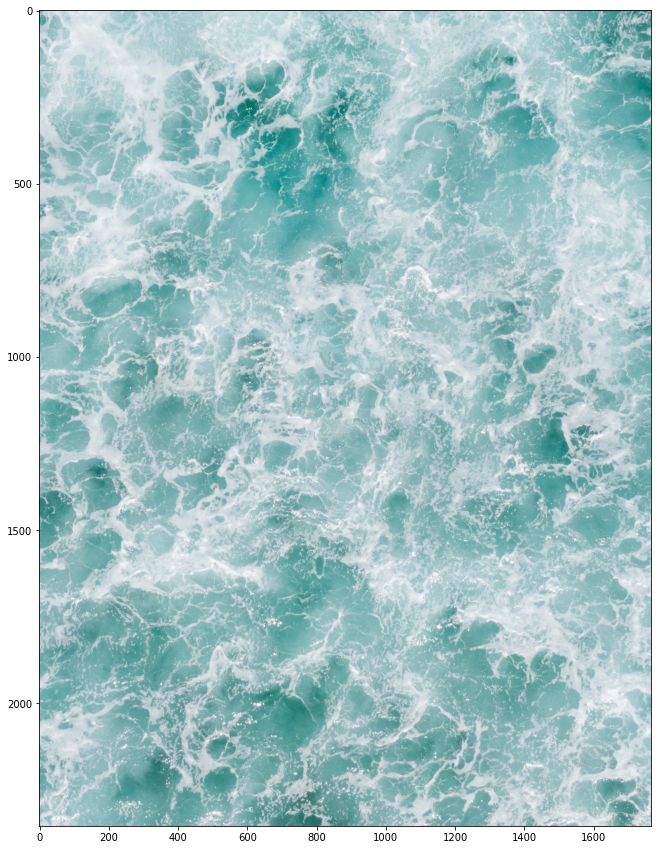

In [55]:
plt.figure(figsize=(15, 15))
plt.imshow(cv.cvtColor(result.astype(np.uint8), cv.COLOR_BGR2RGB));

## Test on another example

In [38]:
main_img = cv.imread('im03.jpg').astype(np.float32)
main_img.shape

(960, 1440, 3)

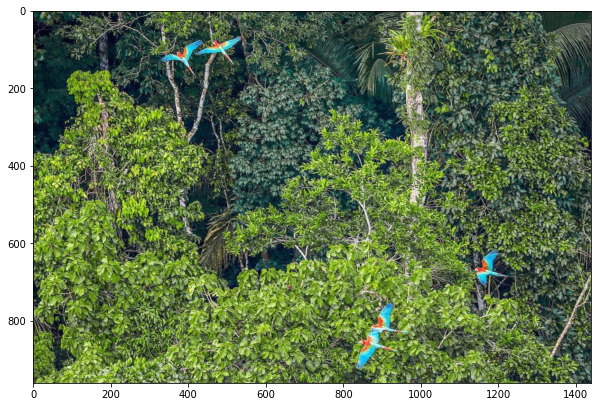

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(main_img.astype(np.uint8), cv.COLOR_BGR2RGB));

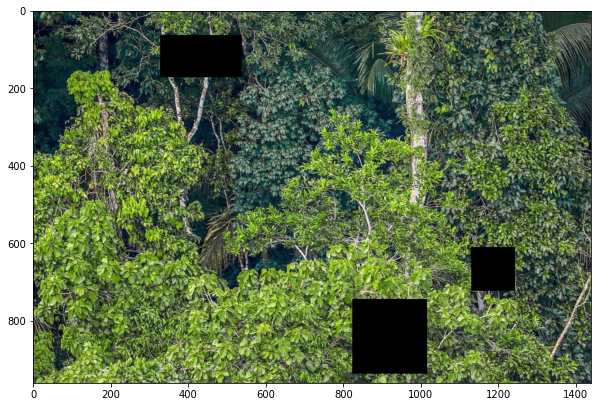

In [40]:
rectangles = [
    ([609, 1131], [722, 1244]),
    ([743, 824], [936, 1017]),
    ([62, 328], [171, 539])
]
main_mask = np.ones_like(main_img, dtype=bool)
for rect_coords in rectangles:
    main_mask[rect_coords[0][0]:rect_coords[1][0], rect_coords[0][1]:rect_coords[1][1]] = False
main_img[~main_mask] = 0
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(main_img.astype(np.uint8), cv.COLOR_BGR2RGB));

In [41]:
result = fill_in_rectangles_img(main_mask, main_img, rectangles, windows_size=95, overlap=5)

100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


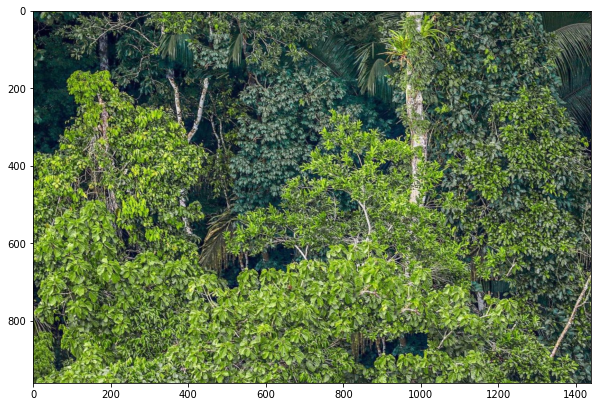

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(result.astype(np.uint8), cv.COLOR_BGR2RGB));